# Probability Distributions and Random Variables

To embark on an exciting journey into the realm of probabilistic thinking and programming, it's essential to establish a solid foundation. This foundation entails gaining a comprehensive understanding of probability distributions, mastering fundamental probability principles, and acquiring the skills to manipulate probabilities within code.

Probability distributions and random variables serve as tools for describing and performing calculations related to random events, specifically those whose outcomes are uncertain. An illustrative instance of such an uncertain event would be the act of flipping a coin or rolling a dice. In the former case, the potential outcomes are heads or tails.

*In the context of epidemiological modelling, we will encounter data of different type and origin. It is crucial to grasp the suitability of different probability distributions for modeling specific types of data.*

Since the PPL we will be using for this course is **Numpyro**, also in this section we will use the implementations of distribution from this library `import numpyro.distributions as dist`

In [2]:
# uncomment this line on Colab
# !pip install numpyro

In [3]:
import jax
import jax.numpy as jnp

# dsitributions
import numpyro.distributions as dist

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Since we are using jax, we will need a random key:
rng = jax.random.PRNGKey(42)

/opt/anaconda3/envs/aims/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1706476165.420460       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Discrete Distributions

### The Bernoulli distribution

A Bernoulli distribution is used to describe random events with two possible outcomes e.g. when we have a random variable $X$ that takes on one of the two values $x \in \{0, 1\}$ with probabilities $1-p$ and $p, 0 \le p \le 1$ respectively:

\begin{align*}
p(X = 1) &= p, \\
p(X = 0) &= 1 - p.
\end{align*}

Here $p$ is the probability of the 'positive' outcome. For example, in the case of a *fair* coin toss, $p = 0.5$ so that both outcomes have a 50\% chance of occurring. As we will see shortly, most distributions have multiple parameters.

#### Probability mass function
A *discrete* probability distribution can be uniquely defined by its *probability mass function (PMF)*.

```{margin}
The term 'mass' is used to underline that the support of the distribution is discrete, and each possible values carries a certain `mass` (probability).
For continuous distributions, the analogous is *probability density function (PDF)*, we will see those later.
```
For the Bernoulli distribution, we write the PMF as

\begin{align*}
p(X = x) = \text{Bernoulli}(X\mid p) &= \begin{cases}
p\, & \text{if } x = 1 \\
1 - p\, & \text{if } x = 0
\end{cases} \\
&= p^x(1-p)^{1-x}.
\end{align*}

**Exercise:** convince yourself that the two definitions of the Bernoulli distribution shown above are equivalent.

Now let's construct a Bernoulli distribution in code so that we can play around with it and get some intuition.

**Note:** In this practical, we are going to use `numpyro` to construct our distributions. However, there are several other `jax` packages that work similarly (e.g., `distrax`) as well as several options for `tensorflow` (e.g., `tensorflow_probability`) and `pytorch` (e.g., `torch.distribution`). Don't worry too much about the specifics of how `numpyro` works, e.g., the names of the distributions and their arguments. Instead try to understand what the code is doing.

#### Drawing a sample

We construct the distribution with a certain value of the parameter `p`:

In [4]:
p = jnp.array(0.5)
bernoulli = dist.Bernoulli(probs=p)

Now that we have constructed the distribution we can get a *sample* from it:

```{margin}
We can think of a sample as a realisation of the random variable. 
```

In [5]:
sample = bernoulli.sample(key=rng)
print(sample)

1


And we can evaluate the probability of observing a sample.

**Note:** the distribution objects in `numpyro` (and indeed most other libraries for probability distributions) return *log*-probabilities rather than raw probabilities. This means that we need to take the exponent if we want to know the probability.

In [6]:
log_prob = bernoulli.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 1) = -0.6931471824645996
p(X = 1) = 0.5


As expected, we get a probability of 0.5.

#### Multiple samples

We can also easily get multiple samples:

```{margin}
Multiple samples are different realisations of the *same* random variable.
```

In [7]:
n_samps = 7
samples = bernoulli.sample(key=rng, sample_shape=(n_samps,))
print(samples)

[0 0 1 1 0 1 1]


What if we wanted to evaluate the probability of observing all of our samples?

The `bernoulli` object we created earlier treats each sample individually and returns the probabilities of observing each sample on its own:

In [8]:
individual_sample_probs = jnp.exp(bernoulli.log_prob(samples))
print(individual_sample_probs)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5]


But, we can use one of the laws of probability to compute the probability of observing all of the samples together:

\begin{align*}
p(X_1=x_1, X_2=x_2, \dots, X_N=x_n) = \prod_{n=1}^N p(X_n=x_n).
\end{align*}

This is called the *product rule of probability*, and it says that for *independent* random variables, the joint probability (i.e., the probability of observing them all together) is equal to the product of the individual probabilities.

Now, let's calculate the joint probability of our samples.

```{margin}
Working with log-probabilities is preferable due to numerical stability, computational efficiency, and ease of handling multiplicative operations.
```

In [9]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

0.0078125


#### Visualise PMF

Now let's visualise the PMF:

In [10]:
def Bernouilli_vis(rng, p, n_samps):

    # define distribution
    bernoulli_ = dist.Bernoulli(probs=p)

    # collect samples
    samples = bernoulli_.sample(key=rng, sample_shape=(n_samps,))

    # how many ones
    num_ones = (samples == 1.).sum()

    # how many zeros
    num_zeros = (samples == 0.).sum()

    # plot
    fig = plt.figure(dpi=100, figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar([0, 1], [num_zeros/n_samps, num_ones/n_samps], alpha=0.7)
    ax.set_xticks([0, 1])
    ax.set_xlabel('Outcome (x)')
    ax.set_ylabel('Probability Mass p(X=x)')
    ax.set_title(f'Bernoulli Distribution (p={p})')
    
    plt.show()



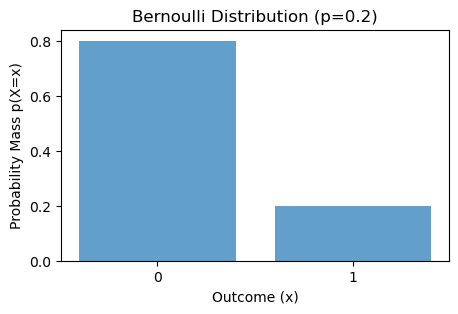

In [11]:
Bernouilli_vis(rng, p=0.2, n_samps=10)

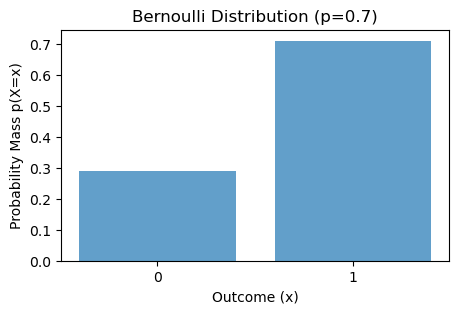

In [12]:
Bernouilli_vis(rng, p=0.7, n_samps=100)

**Exercise:**  plot a panel of histograms where you vary probability $p$ horizontally and numher of samples $n$ vertically. 

### The Binomial distribution

A binomial distribution is a discrete probability distribution that models the number of successes "x" in a fixed number of independent and identical Bernoulli trials, where each trial has only two possible outcomes: success or failure. 

Key characteristics of a binomial distribution:

- Two Outcomes: Each trial results in one of two possible outcomes, typically denoted as "success" (represented as "1") or "failure" (represented as "0" or "not a success").

- Fixed Number of Trials ($n$): The distribution considers a fixed number of trials, denoted as $n$, which is the total number of times the event is repeated.

- Probability of Success ($p$): The probability of success on each individual trial is constant and denoted as $p$. 

- Independence: Each trial is assumed to be independent, meaning the outcome of one trial does not affect the outcome of another.

#### Probability mass function

$$P(X = x) = \binom{n}{x} p^x (1 - p)^{n - x},$$

where

- $P(X = x)$ is the probability of getting exactly $x$ successes,

- $\binom{n}{x}$ is the binomial coefficient, representing the number of ways to choose $x$ successes out of $n$ trials,

- $p$ is the probability of success on a single trial,

- $1-p$ is the probability of failure on a single trial,

- the bnumber of successes $x$ ranges from $0$ to $n$ inclusive.

#### Drawing a sample

As before, we begin by constructing the distribution:

In [13]:
p = 0.3
n = 10
binomial = dist.Binomial(total_count=n, probs=p)

Now we can draw a sample from this distribution:

In [14]:
sample = binomial.sample(key=rng)
print(sample)

4


What is the probability to observe this sample?

In [15]:
log_prob = binomial.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 4) = -1.608832836151123
p(X = 4) = 0.20012104511260986


#### Multiple samples

Let us generate samples repeatedly: 

In [16]:
n_samps = 7
samples = binomial.sample(key=rng, sample_shape=(n_samps,))
print(samples)

[3 6 1 3 2 4 5]


Individual probabilities to observe the samples:

In [17]:
individual_sample_probs = jnp.exp(binomial.log_prob(samples))
print(individual_sample_probs)

[0.26682812 0.03675695 0.12106086 0.26682812 0.23347507 0.20012105
 0.10291947]


Assuming that teh samples are independent, what is the joint probability ob observeing them?

In [18]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

1.5234818e-06


#### Visualise PMF

In [19]:
def binomial_vis(rng, p, n, x_ticks=True):
    
    # Binomial distribution with n trials and probability of success p
    binomial = dist.Binomial(total_count=n, probs=p)
    
    # Generate the possible outcomes (x values)
    x_values = jnp.arange(0, n + 1)

    pmf_values = jnp.exp(binomial.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.bar(x_values, pmf_values, align='center', alpha=0.7)
    plt.xlabel('Number of Successes (x)')
    plt.ylabel('Probability Mass p(X=x)')
    plt.title(f'Binomial Distribution (n={n}, p={p})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


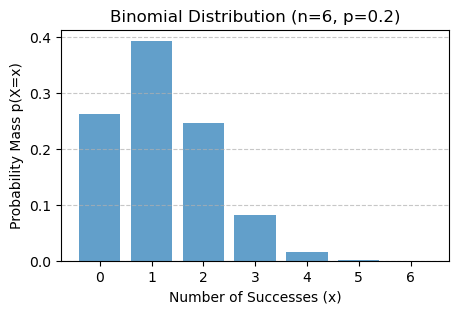

In [20]:
binomial_vis(rng, p=0.2, n=6)

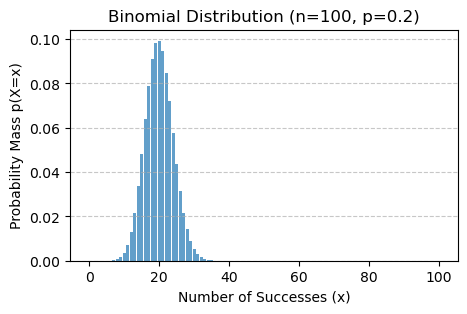

In [21]:
binomial_vis(rng, p=0.2, n=100, x_ticks=False)

**Exercise:**  what is qualitatively different between the distributions `Bernoulli(p=0.2, n=6)` and `Bernoulli(p=0.2, n=100)`?

### The Categorical distribution

A categorical distribution is used to model random events with multiple *discrete* outcomes, such as the die-rolling event from above. By discrete, we mean that there is a finite number of outcomes. We will tackle continuous outcomes – e.g., a value like temperature that is modeled by a real numbers – shortly.

As with the Bernoulli distribution, we can characterise the categorical distribution with its PMF:
\begin{align*}
p(X = x) = \text{categorical}(X\mid\mathbf{p}) = \prod_{k=1}^K p_k^{[x=k]},
\end{align*}
where $K$ is the number of outcomes, $\textbf{p} = [p_1, p_2, \dots, p_K]$, $p_k$ is the probability of the $k$th outcome, $\sum_k p_k = 1$, and $[x = k]$ is called an Iverson bracket which evaluates to 1 if $x = k$ and 0 otherwise.

**Exercise:** convince yourself that a categorical distribution with $K = 2$ is equivalent to a Bernoulli distribution.

In [22]:
ps = jnp.array([0.1, 0.2, 0.3, 0.4])
categorical = dist.Categorical(probs=ps)

As before we can take some samples:

In [23]:
samples = categorical.sample(key=rng, sample_shape=(10,))
print(samples)

[3 2 1 3 3 1 2 1 3 3]


In [24]:
print(f"p(X=0) = {jnp.exp(categorical.log_prob(0)):.1f}")
print(f"p(X=1) = {jnp.exp(categorical.log_prob(1)):.1f}")
print(f"p(X=2) = {jnp.exp(categorical.log_prob(2)):.1f}")
print(f"p(X=3) = {jnp.exp(categorical.log_prob(3)):.1f}")

p(X=0) = 0.1
p(X=1) = 0.2
p(X=2) = 0.3
p(X=3) = 0.4


**Group task 5:** Play with the following sliders, which control the parameters of the categorical distribution. Note that because $\sum_k p_k = 1$, we are using an alternative way to represent the categorical distribution. Instead of specifying the probabilities $p_k$, we specify logits $l_k$. Each $p_k$ is then computed as
$$
p_k = \frac{\exp(l_k)}{\sum_{k'}\exp(l_k)},
$$
i.e., using the softmax function.

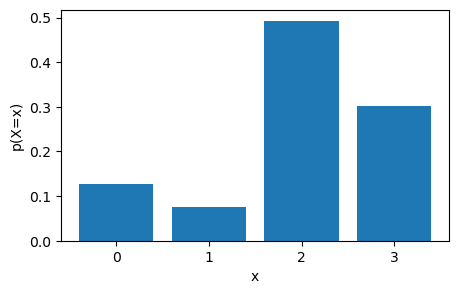

In [25]:
l_0 = 0.7 
l_1 = 0.3 
l_2 = 2 
l_3 = 1.6

logits = jnp.array([l_0, l_1, l_2, l_3], dtype=jnp.float32)
categorical = dist.Categorical(logits=logits)
samples = categorical.sample(key=rng, sample_shape=(1000,))

values =[0, 1, 2, 3]
hist, _ = jnp.histogram(
    samples, bins=jnp.array(values + [4]), density=True
)

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar(values, hist)
ax.set_xticks(values)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()

### The Ordered distribution

## Continuous Distributions

### The Beta distribution

The next distribution on our *grand tour of probability distributions* is the beta distribution. We're taking a look at this for two reasons. Firstly, we just want to take a look at a continuous probability distribution that *isn't* normal for the sake of getting some new perspective. Secondly, this distribution will be useful later in the practical – so if you aren't already familiar with it, stick around for this section.

The beta distribution can be used to describe a continuous random variable between 0 and 1, for example, percentages and ratios. It has the following form
$$
p(X = x) = \mathrm{Beta}(x|\alpha,\beta) = \frac{1}{\mathrm{B}(\alpha,\beta)}x^{\alpha-1}(1 - x)^{\beta - 1},
$$
where $\alpha > 0$ and $\beta > 0$ are the two *shape* parameters of the distribution, and $\mathrm{Beta}$ is called the beta function. Don't worry about the exact form of the beta function, all you need to know is that we can easily compute it using `numpy` or similar libraries, and it just ensures that the probability distribution is normalised – that is, that the total probability of all of the events adds up to 1. Instead, let's play around with the following sliders to get an idea of what the beta distribution looks like.
* Try making each parameter big or small while leaving the other at the same value.
* Then try make them both big or small.

We're just trying to get a feel for the kinds of behavior the beta distribution can describe, and how it is different from the normal distribution. Later on we'll use the beta distribution in an example, which will help us get some further intuition for this distribution.

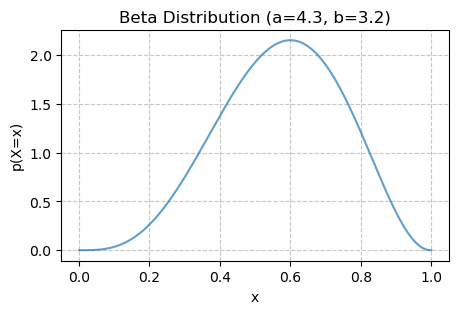

In [62]:
def beta_vis(a, b, x_ticks=True):
    
    beta = dist.Beta(a, b)
    
    x_values = jnp.linspace(0, 1, 1000)

    pmf_values = jnp.exp(beta.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.plot(x_values, pmf_values, alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('p(X=x)')
    plt.title(f'Beta Distribution (a={a}, b={b})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    #plt.grid(0.3)

    plt.show()

beta_vis(a=4.3, b=3.2, x_ticks=False)

### The Gamma distribution

The Gamma distribution is a continuous distribution with support in $\mathbb{R}^+$.
Its PDF has the form 

$$p(X=x) = \mathrm{Gamma}(x; \alpha, \beta) = \frac{ \beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x},$$

where $\alpha>0$ is the shape parameter, which determines the shape of the distribution, and $\beta>0$ is the scale parameter. 


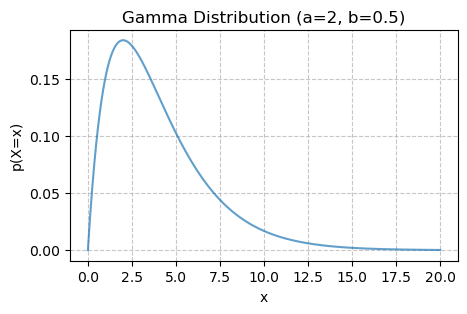

In [66]:
def gamma_vis(a, b, x_ticks=True):
    
    gamma = dist.Gamma(a, b)
    
    x_values = jnp.linspace(0, 20, 1000)

    pmf_values = jnp.exp(gamma.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.plot(x_values, pmf_values, alpha=0.7)
    plt.xlabel('x')
    plt.ylabel('p(X=x)')
    plt.title(f'Gamma Distribution (a={a}, b={b})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    #plt.grid(0.3)

    plt.show()

gamma_vis(a=2, b=0.5, x_ticks=False)

### The Uniform distribution

For the sake of completeness, let's formally introduce one of the most simple continuous distributions – the uniform distribution. Under this distribution, all possible values are equally likely. The uniform distribution has the following form
$$
p(X = x) = \mathrm{Uniform}(x\mid a, b) = \begin{cases}
\frac{1}{b - a}\, & \text{if } a \le x \le b \\
0\, & \text{otherwise},
\end{cases}
$$
where $a$ and $b$ are the upper and lower bound parameters, respectively.

As has been our custom, here is an interactive plot of the distribution if you'd like to get a better picture.

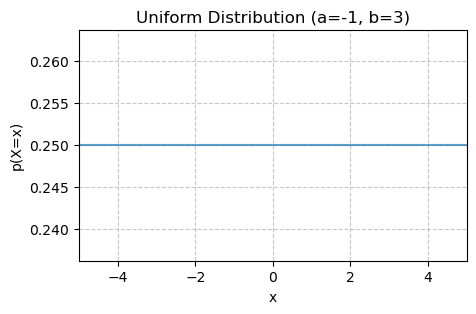

Array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

In [70]:
a = -1
b = 3 
x_ticks= False

uniform = dist.Uniform(low=a, high=b)
x_values = jnp.linspace(-5, 5, 1000)

pmf_values = jnp.exp(uniform.log_prob(x_values))

fig = plt.figure(dpi=100, figsize=(5, 3))
plt.plot(x_values, pmf_values, alpha=0.7)
plt.xlabel('x')
plt.ylabel('p(X=x)')
plt.title(f'Uniform Distribution (a={a}, b={b})')
if x_ticks:
    plt.xticks(x_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(-5, 5)

plt.show()


#fig = plt.figure(dpi=100, figsize=(5, 3))
#ax = fig.add_subplot(1, 1, 1)
#ax.plot(xs, jnp.exp(uniform.log_prob(xs)), color='C0', lw=3, alpha=0.5)
#ax.set_xlabel('x')
#ax.set_ylabel('p(X=x)')
#ax.grid(0.3)
#ax.set_xlim(-5, 5)
#plt.show()


### The Normal distribution

The normal – also known as Gaussian – distribution is one of the most common distributions for modeling *continuous* random variables, i.e., corresponding to events with an uncountable number of outcomes. Its probability density function is
$$
p(X = x) = \mathcal{N}(x\mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mu - x)^2}{2\sigma^2}\right),
$$
where $\mu$ and $\sigma$ are the *mean* and *standard deviation* (also called the location, and scale or square-root of the *variance* $\sigma^2$, respectively).

Once again, the best way to get a sense for this distribution is to play with some code!

**Group task:** how do the mean and standard deviation affect the samples?

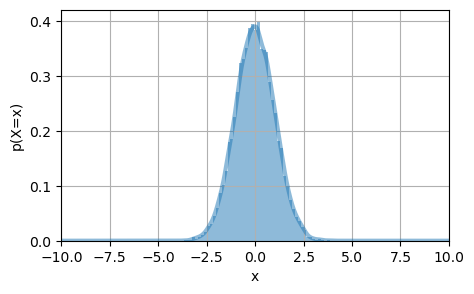

In [29]:
mu = 0 
sigma = 1 

normal = dist.Normal(loc=mu, scale=sigma)
samples = normal.sample(key=rng, sample_shape=(10000,))

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(samples, bins=50, density=True, alpha=0.5)
x = jnp.linspace(-10, 10, 3000)
kde = gaussian_kde(samples)
ax.plot(x, kde(x), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.set_xlim(-10, 10)
ax.grid(0.3)
plt.show()

Implementing the normal PDF from scratch:

In [30]:
def test_normal_pdf(pdf_fn):
  assert pdf_fn(0, 1, 0) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(0)), "Normal(X=0|0, 1) is incorrect."
  assert pdf_fn(0, 2, 0) == jnp.exp(dist.Normal(loc=0, scale=2).log_prob(0)), "Normal(X=0|0, 2) is incorrect."
  assert pdf_fn(0, 1, 1) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(1)), "Normal(X=0|1, 1) is incorrect."
  assert pdf_fn(2, 3, 1) == jnp.exp(dist.Normal(loc=2, scale=3).log_prob(1)), "Normal(X=1|2, 3) is incorrect."
  print("Nice! Your answer looks correct.")

In [31]:
def normal_pdf(loc, scale, x):
    p_x = 1 / jnp.sqrt(2 * jnp.pi * scale**2)
    p_x *= jnp.exp(-((loc - x)**2) / (2 * scale**2))

    return p_x

test_normal_pdf(normal_pdf)

Nice! Your answer looks correct.


### The Multivariate Normal distribution

The multivariate normal distribution is a generalization of the normal distribution to consider multiple random variables that have a jointly normal distribution. In other words, it lets us model variables that are not independent – if we know the value of one variable, that tells us something about the other variables!
More concretely, the multivariate normal distribution lets us consider multiple random variables such that when we condition on some of these variables the remaining variables have a normal distribution (don't worry if you don't know what "condition on" means yet; we'll discuss it shortly). These variables are distributed in a kind of stretched fuzzy ball in higher dimensional space.
As a rule of thumb, the more one variable tells us about another, the larger the *covariance* or *correlation* between the two. Enough text, let's take a look at the equations, which will hopefully give some further insight. First, let's look at the general PDF for an $D$-dimensional random variable $\mathbf{X}$:
$$
p(\mathbf{X} = \mathbf{x}) = \mathcal{N}(\mathbf{x}\mid \boldsymbol{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^D|\Sigma|}}\exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^\intercal\Sigma^{-1}(\mathbf{x} - \boldsymbol{\mu})\right),
$$
where $\mathbf{x}$ and $\boldsymbol{\mu}$ are now vectors of numbers rather than single numbers, $\Sigma$ is a *covariance matrix* that replaces $\sigma$ from our univariate definition above, and $|\Sigma|$ is its determinant. The covariance matrix looks like this:
\begin{equation*}
\Sigma = \begin{bmatrix}\sigma_1^2 & \rho_{12} \sigma_1 \sigma_2 & \cdots &  \rho_{1D} \sigma_1 \sigma_D  \\
    \rho_{21} \sigma_2\sigma_1 & \sigma_2^2 & \cdots &  \rho_{2D} \sigma_2 \sigma_D \\
    \vdots & \vdots & \ddots & \vdots \\
    \rho_{D1} \sigma_D \sigma_1 & \rho_{D2} \sigma_D \sigma_2 & \cdots & \sigma_D^2 \end{bmatrix}
\end{equation*}

where $\sigma_i^2$ is the variance for the $i$-th dimension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$-th and $j$-th dimensions. The covariance matrix tells us how the "ball" of random variables is stretched and rotated in space.

**Task:** If you and your neighbors are very comfortable with matrix algebra, try and convince yourselves that the equation above is equivalent to the univariate case when $D = 1$.

Now let's look at how the equation above simplifies in the two-dimensional case!
$$
p(X_1 = x_1, X_2 = x_2) = \mathcal{N}\left( \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \middle| \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \begin{bmatrix} \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2 \end{bmatrix}\right)\\
= \frac{1}{2\pi\sigma_1\sigma_2\sqrt{1 - \rho^2}}\exp\left(-\frac{1}{2(1 - \rho^2)}\left[\left(\frac{x_1 - \mu_1}{\sigma_1}\right)^2 -2\rho\left(\frac{x_1 - \mu_1}{\sigma_1}\right)\left(\frac{x_2 - \mu_2}{\sigma_2}\right)  + \left(\frac{x_2 - \mu_2}{\sigma_2}\right)^2 \right] \right)
$$

**Group task 9:** Let's try to understand what this equation means. Discuss the following questions with your neighbors. If the answers don't seem obvious to you, don't worry! As usual, we have some code to play with to help our understanding, so feel free to use any combination of mathematics and playing with sliders to help you understand. If playing with the sliders still doesn't help, don't worry, the next section will also make things clearer.
1. If $\rho = 0$, how does this two-dimensional case relate to the one-dimensional case above?
2. Now, think about what happens as $\rho$ becomes larger? What if it becomes negative?

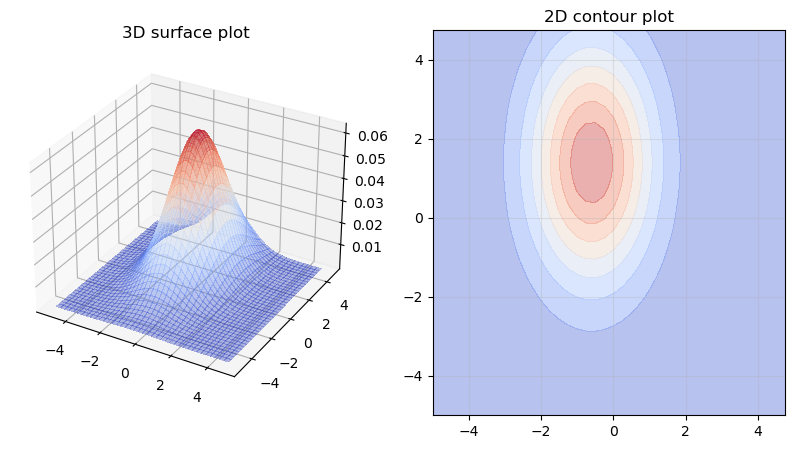

In [32]:

from matplotlib import gridspec
from scipy.stats import norm

mu1 = -0.6 #@param {type:"slider", min:-5, max:5, step:0.1}
sigma1 = 1.2 #@param {type:"slider", min: 0.1, max:4, step:0.1}
mu2 = 1.4 #@param {type:"slider", min:-5, max:5, step:0.1}
sigma2 = 2.1 #@param {type:"slider", min: 0.1, max:4, step:0.1}
rho = 0 #@param {type:"slider", min: -1, max:1, step:0.1}

mu = jnp.array([mu1, mu2])
Sigma = jnp.array([[sigma1**2, rho*sigma1*sigma2],[rho*sigma2*sigma1, sigma2**2]])

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')

X1 = jnp.arange(-5, 5, 0.25)
X2 = jnp.arange(-5, 5, 0.25)
X1, X2 = jnp.meshgrid(X1, X2)
Xs = jnp.concatenate(
    [X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1
)
Z = jax.vmap(
    lambda x: jnp.exp(dist.MultivariateNormal(mu, Sigma).log_prob(x))
)(Xs).reshape(X1.shape)

from matplotlib import cm
ax1.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                linewidth=0, alpha=0.4, antialiased=False)
ax1.set_title('3D surface plot')


ax2 = fig.add_subplot(122)
ax2.contourf(X1, X2, Z, cmap=cm.coolwarm,
            alpha=0.4, antialiased=False)
ax2.set_title('2D contour plot')


ax2.grid(alpha=0.3)
plt.show()

In [33]:
# @title Helper Functions. (Run Cell)

def Gaussian_conditional(mean, cov, x=None,y=None):
  assert not (x is None and y is None) and not (x is not None and y is not None)
  if x is not None:
    var = cov[1,1] -  cov[1,0] * cov[0,0] ** (-1) * cov[0,1]
    mu = mean[1] + cov[1,0] * cov[0,0] ** (-1) * (x - mean[0])
  else:
    var = cov[0,0] -  cov[0,1] * cov[1,1] ** (-1) * cov[1,0]
    mu = mean[0] + cov[0,1] * cov[1,1] ** (-1) * (y - mean[1])
  return mu, var**0.5

def plot_log_gaussian_ellipse(ax, mean, cov, color='b', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[1, 2, 4, 6]):

  eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
  theta = jnp.linspace(0, 2*jnp.pi, 1200);
  std_ellipsis = (jnp.sqrt(eigenvalues[None,:]) * eigenvectors) @ jnp.stack([jnp.sin(theta), jnp.cos(theta)])

  artists = []

  for level in std_levels:
    artists.append(ax.plot(mean[0] + level*std_ellipsis[0,:],
                           mean[1] + level*std_ellipsis[1,:], c=color,
                           alpha=alpha, lw=lw))

  artists.append(ax.scatter([mean[0]], [mean[1]], MAP_size, color=color,
                            label=label, alpha=alpha, marker='x'))

  return artists

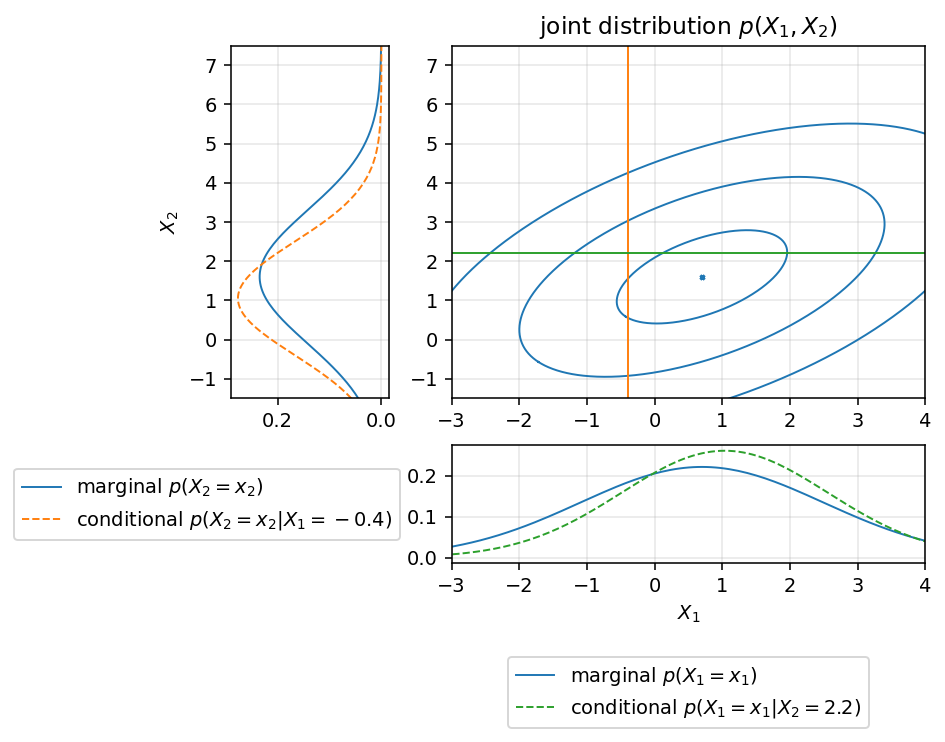

In [34]:

from matplotlib import gridspec
from scipy.stats import norm

μ1 = 0.7 #@param {type:"slider", min:-5, max:5, step:0.1}
σ1 = 1.8 #@param {type:"slider", min: 0.1, max:4, step:0.1}
μ2 = 1.6 #@param {type:"slider", min:-5, max:5, step:0.1}
σ2 = 1.7 #@param {type:"slider", min: 0.1, max:4, step:0.1}
ρ = 0.529 #@param {type:"slider", min: -0.999, max:0.999, step:0.001}
x1 = -0.4 #@param {type:"slider", min:-5, max:5, step:0.1}
x2 = 2.2 #@param {type:"slider", min:-5, max:5, step:0.1}

μ = jnp.array([μ1, μ2])
Σ = jnp.array([[σ1**2, ρ*σ1*σ2],[ρ*σ2*σ1, σ2**2]])

cond_μ_x1, cond_σ_x1 = Gaussian_conditional(μ, Σ, x=None, y=x2)
cond_μ_x2, cond_σ_x2 = Gaussian_conditional(μ, Σ, x=x1, y=None)

xrange = jnp.linspace(-10, 10, 300)
density_x1 = norm.pdf(xrange, μ1, σ1)
density_x2 = norm.pdf(xrange, μ2, σ2)

cond_density_x1 = norm.pdf(xrange, cond_μ_x1, cond_σ_x1)
cond_density_x2 = norm.pdf(xrange, cond_μ_x2, cond_σ_x2)

plt.figure(dpi=140)
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

plot_log_gaussian_ellipse(ax, μ, Σ, color='C0', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[0.7, 1.5, 2.3])
ax.set_title('joint distribution $p(X_1, X_2)$')
ax.axvline(x1, lw=1, c='C1')
ax.axhline(x2, lw=1, c='C2')

axb.plot(xrange, density_x1, c='C0', lw=1, label='marginal $p(X_1=x_1)$')
axb.plot(xrange, cond_density_x1, '--', c='C2', lw=1, label=f'conditional $p(X_1=x_1 | X_2={x2})$')
axb.set_xlabel('$X_1$')
axb.set_xlim([-3,4])
axb.legend(bbox_to_anchor=[0.5, -1.1],
           loc='center')

axl.plot(density_x2, xrange, c='C0', lw=1, label='marginal $p(X_2 = x_2)$')
axl.plot(cond_density_x2, xrange, '--', c='C1', lw=1, label=f'conditional $p(X_2 = x_2 | X_1={x1})$')
axl.set_ylabel('$X_2$')
axl.set_ylim([-1.5,7.5])
axl.invert_xaxis()
axl.legend(bbox_to_anchor=[-0.15, -0.3],
           loc='center')

ax.grid(alpha=0.3)
axl.grid(alpha=0.3)
axb.grid(alpha=0.3)
plt.show()

## Batch and event shapes

Let's take a moment to play with some code for both the multivariate normal and its simpler friend, the univariate normal. We'll take this opportunity to learn something about how `numpyro` (and most other packages for working with probability distributions) handle batches of data – something we'll have to understand for training machine learning models!

All distributions in `numpyro` have an `event_shape` – which describes how my dimensions the random variable is, e.g., for a 2-dimensional normal distribution this would be 2 – and a `batch_shape` which describes how many sets of parameters the distribution has – it is probably easier to show what this means with the following examples rather than tell.

Let's first look at a simple univariate normal $\mathcal{N}(x|0, 1)$, as we've seen before in this practical. We will evaluate the probabilities of $X = 1$ and $X = 2$:

In [35]:
values = jnp.array([1., 2.])
normal = dist.Normal(0., 1.)
print(f"event_shape = {normal.event_shape}")
print(f"batch_shape = {normal.batch_shape}")
print(f"p(X = {values}) = {jnp.exp(normal.log_prob(values))}")

event_shape = ()
batch_shape = ()
p(X = [1. 2.]) = [0.24197073 0.05399096]


We see that this distribution has an empty event shape, which you can think of as being the same as an event shape of 1 (like how a scalar is the same as a vector of length 1). The batch shape is also empty, since we only specified one set of parameters ($\mu = 0, \sigma = 1$).  

Now since we tried to evaluate the probability of two values at once, and neither the event shape nor the batch shape are 2, this is equivalent to calling `dist.log_prob(1.)` and `dist.log_prob(2.)` separately. `numpyro` is just making our lives easier by *broadcasting* the `log_prob` calculation to do both $p(X=1) = \mathcal{N}(X=1|0, 1)$ and $p(X=2) = mathcal{N}(X=2|0, 1)$ at the same time.

We could also specify a *batch* of two sets of parameters so that we are essentially working with $\mathcal{N}(x|0, 1)$ and $\mathcal{N}(x|1, 2)$ at the same time:

In [36]:
batch_normal = dist.Normal(jnp.array([0., 1.]), jnp.array([1., 2.]))
print(f"event_shape = {batch_normal.event_shape}")
print(f"batch_shape = {batch_normal.batch_shape}")
print(f"[p(X_1 = {values[0]}), p(X_2 = {values[1]})] = {jnp.exp(batch_normal.log_prob(values))}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.prod(jnp.exp(batch_normal.log_prob(values)))}")

event_shape = ()
batch_shape = (2,)
[p(X_1 = 1.0), p(X_2 = 2.0)] = [0.24197073 0.17603266]
p(X_1 = 1.0, X_2 = 2.0) = 0.042594753205776215


Now, notice that while the event shape is empty (as expected since we are still working with a univariate normal), the batch size is 2!

As a result, the calculation we are doing is equivalent to separately calculating $p(X_1=1) = \mathcal{N}(X_1=1|0, 1)$ and $p(X_2=2) = \mathcal{N}(X_2=2|1, 2)$! Again, this is just `numpyro` making our lives easier.

If we want to calculate $p(X_1=1,X_2=2)$, i.e., the joint probability that $X_1 = 1$ and $X_2 = 2$, then we either need to manually multiply the probabilities (assuming that $X_1$ and $X_2$ are independent) – as we've in the cell above – or we need to work with a multivariate normal.

Let's first look at the case when the $X_1$ and $X_2$ are independent:

In [37]:
multivariate_full_normal = dist.MultivariateNormal(jnp.array([0., 1.]), jnp.array([[1., 1.], [1., 2.**2]]))
print(f"event_shape = {multivariate_full_normal.event_shape}")
print(f"batch_shape = {multivariate_full_normal.batch_shape}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.exp(multivariate_full_normal.log_prob(values))}")

event_shape = (2,)
batch_shape = ()


p(X_1 = 1.0, X_2 = 2.0) = 0.055732980370521545


This results in a slightly different value for the joint probability, but otherwise everything looks the same.

Of course, we can get a bit crazy and we can have non-empty event shape *and* a non-empty batch shape, but we'll leave that as a homework exercise for the curious to play with.